In [1]:
import nilearn
from nilearn import plotting
from nilearn import image

import numpy as np
import pandas as pd

from nilearn.image import mean_img,math_img,index_img,concat_imgs

C:\Users\Asus\AppData\Roaming\Python\Python38\site-packages\nilearn\datasets\__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Creating files for events and labels for each run and for all 3 of them

In [2]:
from nilearn.image import mean_img,math_img,index_img,concat_imgs
import os

path='C:\\Users\\Asus\\Documents\\3oAno\\Estágio\\Dados'

n_subjects=2
n_sessions=1
n_runs=3
sub='sub-000%d' %n_subjects
ses='ses-00%d' %n_sessions

tr=2

events_bs_target=None

classification_target=None

idx_run=1
idx_suj=1
# Iterate runs.
for f in range(n_subjects):
    sub='sub-000%d' %idx_suj
    
    for i in range(n_runs):
        run='run-0%d' %idx_run
        # Load data for each RUN r.
        events_PATH=os.path.join('%s\\%s_%s_task-innerspeech_%s_events.tsv' % (path,sub,ses,run))
        labels_d=pd.read_csv(events_PATH, sep='\t', na_values="n/a")

        onset=[]
        duration=[]
        trialtype=[]

        labels=[]
        onsett=0
        evtt=0

        #Beta-series
        for idx in range(len(labels_d)):
            block_event=labels_d.loc[idx]

            num_evts=block_event['duration']/tr

            for evt in range(int(num_evts)):

                onset.append(onsett)
                onsett+=tr

                duration.append(tr)

                trialtype.append(evtt)
                evtt+=1
                #if evt<int(num_evts)-1:
                labels.append(block_event['trial_type'])

        events_bs = pd.DataFrame({'trial_type': trialtype,
                                  'onset': onset,
                                  'duration': duration}) 
        #Create a file for each run with labels
        df = pd.DataFrame(labels)
        labels_fn=os.path.join('labels_%s_%s.csv' %(sub, run))
        df.to_csv(labels_fn)

        idx_run=idx_run+1
    idx_run=1
    idx_suj=idx_suj+1
len(labels) 

258

### This part is so that the onset won't overwrite other values (onset resets after a run)

In [3]:
idx_run=1
idx_suj=1
auxil_var=None
for f in range(n_subjects):
    sub='sub-000%d' %idx_suj
    for i in range(n_runs):
        run='run-0%d' %idx_run

        # Load data for each RUN r.
        events_PATH=os.path.join('%s\\%s_%s_task-innerspeech_%s_events.tsv' % (path,sub,ses,run))
        labels_d=pd.read_csv(events_PATH, sep='\t', na_values="n/a", usecols=['trial_type', 'onset', 'duration'])
        labels_d.to_csv(os.path.join('block_events_%s_%s.csv' % (sub, run)))
        labels_dir=pd.read_csv(os.path.join('block_events_%s_%s.csv' % (sub, run)))


        for idx in range(len(labels_dir)):
            labels_dir.loc[idx, 'onset'] = labels_dir.loc[idx, 'onset']+258*tr*i+774*tr*f
        if auxil_var is None:
            auxil_var=labels_dir
        else:
            auxil_var=pd.concat((auxil_var, labels_dir))
            if idx_run==3:
                auxil_var.drop('Unnamed: 0', axis='columns', inplace=True)
                auxil_var_d=os.path.join('all_block_events.csv')
                auxil_var.to_csv(auxil_var_d)
        del labels_dir

        idx_run=idx_run+1
    idx_run=1
    idx_suj=idx_suj+1


In [4]:
auxil_var.drop('Unnamed: 0', axis='columns', inplace=True)

In [5]:
print(auxil_var)

   trial_type  onset  duration
0    Baseline      0        12
1     Phrases     12        30
2    Baseline     42        12
3      Vogals     54        30
4    Baseline     84        12
..        ...    ...       ...
20   Baseline   3000        12
21  Syllables   3012        30
22   Baseline   3042        12
23      Words   3054        30
24   Baseline   3084        12

[150 rows x 3 columns]


In [6]:
import os
import nibabel as nib

idx_run=1
idx_suj=1

path='C:\\Users\\Asus\\Documents\\3oAno\\Estágio\\Dados'

bs_maps=None


for f in range(n_subjects):
    sub='sub-000%d' %idx_suj
    for i in range(n_runs):
        run='run-0%d' %idx_run

        #load images

        fmri_img=os.path.join('%s\\%s\\%s\\%s\\%s_%s_task-innerspeech_%s_bold_pp_standard.nii' % (path,sub,ses,run,sub,ses,run))
        bs_map= image.load_img(fmri_img)

        if bs_maps is None:
            bs_maps=bs_map

        else:
            bs_maps=[bs_maps,bs_map]


        del bs_map
        idx_run=idx_run+1
    idx_run=1
    idx_suj=idx_suj+1
    
bs_maps=concat_imgs(bs_maps, auto_resample=True)
print(bs_maps.shape)



(91, 109, 91, 1548)


In [7]:
import nibabel
bs_maps_d=os.path.join('bs_maps')
nibabel.nifti1.save(bs_maps, bs_maps_d)

In [12]:
all_conditions=pd.read_csv(os.path.join('all_block_events.csv'), usecols=['trial_type', 'onset', 'duration'])

In [13]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

tr = 2  # repetition time is 2 seconds
n_scans = bs_maps.shape[3]  # the acquisition comprises ?? scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times


In [14]:
hrf_model='spm'
design_matrix = make_first_level_design_matrix(frame_times, all_conditions,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

<AxesSubplot:label='conditions', ylabel='scan number'>

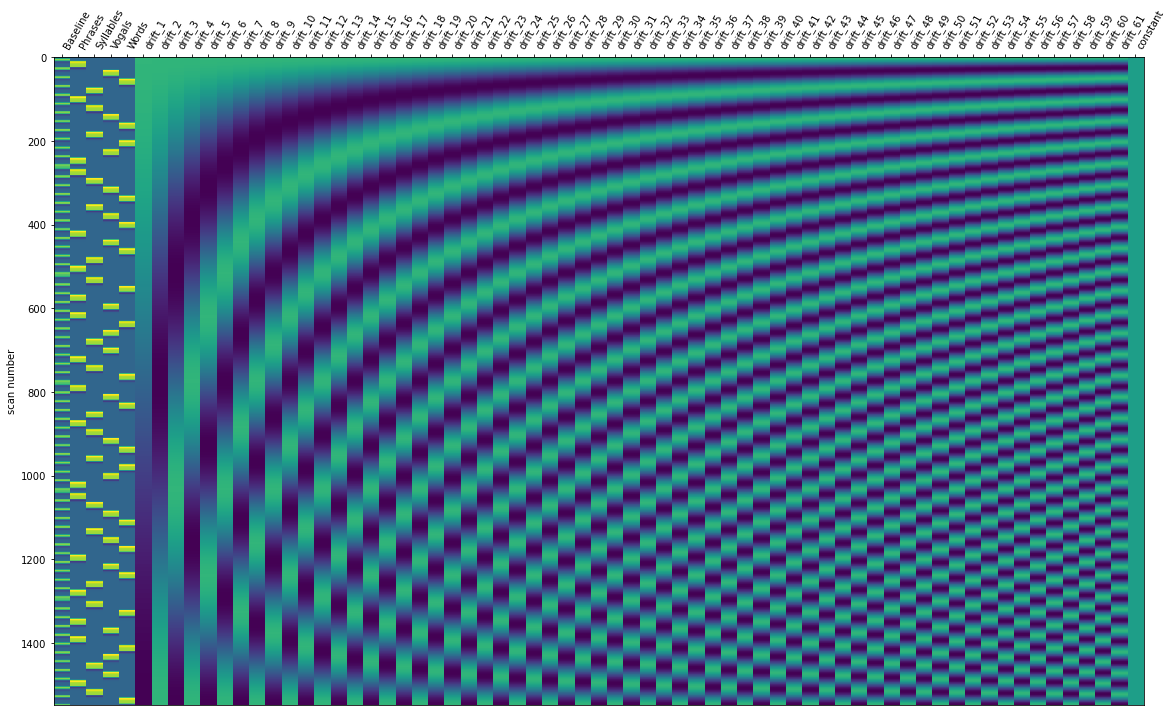

In [15]:
from nilearn.glm.first_level import FirstLevelModel

first_level_model = FirstLevelModel(tr)
first_level_model = first_level_model.fit(bs_maps, events=all_conditions)
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)

In [16]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])

In [17]:
fmri_glm4mask = FirstLevelModel()
fmri_glm4mask = fmri_glm4mask.fit(image.load_img(bs_maps), design_matrices=design_matrix)

In [18]:
#contraste entre as tarefas e baseline
basic_contrasts['+Tasks-Baseline'] = (
    (basic_contrasts['Phrases'] + - basic_contrasts['Baseline']) +
    (basic_contrasts['Syllables'] - basic_contrasts['Baseline']) + 
    (basic_contrasts['Vogals'] - basic_contrasts['Baseline']) + 
    (basic_contrasts['Words'] - basic_contrasts['Baseline']))

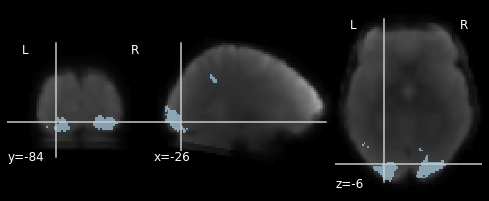

In [23]:
from nilearn.input_data import NiftiMasker

mean_image = image.mean_img(bs_maps)

masker = NiftiMasker()

brain_mask_map = fmri_glm4mask.compute_contrast(basic_contrasts['+Tasks-Baseline'], output_type='z_score')

brain_mask= nilearn.image.threshold_img(brain_mask_map, threshold=4.5, copy=False)
masker.fit(brain_mask)
brain_mask=masker.mask_img_
plotting.plot_roi(brain_mask, bg_img=mean_image,
                  cmap='Paired')

In [24]:
mask_d=os.path.join('mask')
nibabel.nifti1.save(brain_mask, mask_d)